In [102]:
import cv2
import torch
from PIL import Image
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from IPython.display import display

In [22]:
image_path_train = '/content/drive/MyDrive/sign_language_data/sign_mnist_train.csv'
image_path_test = '/content/drive/MyDrive/sign_language_data/sign_mnist_test.csv'
df_train = pd.read_csv(image_path_train)
df_test = pd.read_csv(image_path_test)

In [3]:
# Separate labels and pixel values
labels_train = df_train.iloc[:, 0].values
pixels_train = df_train.iloc[:, 1:].values
print(f"labels = {labels_train}\npixels = {pixels_train}")

labels = [ 3  6  2 ... 18 17 23]
pixels = [[107 118 127 ... 204 203 202]
 [155 157 156 ... 103 135 149]
 [187 188 188 ... 195 194 195]
 ...
 [174 174 174 ... 202 200 200]
 [177 181 184 ...  64  87  93]
 [179 180 180 ... 205 209 215]]


In [4]:
# Separate labels and pixel values
labels_test = df_test.iloc[:, 0].values
pixels_test = df_test.iloc[:, 1:].values
print(f"labels = {labels_test}\npixels = {pixels_test}")

labels = [ 6  5 10 ...  2  4  2]
pixels = [[149 149 150 ... 112 120 107]
 [126 128 131 ... 184 182 180]
 [ 85  88  92 ... 225 224 222]
 ...
 [190 191 190 ... 211 209 208]
 [201 205 208 ...  67  70  63]
 [173 174 173 ... 195 193 192]]


In [5]:
class AlexNet(nn.Module):
  def __init__(self, num_classes, dropout=0.5):
      super(AlexNet, self).__init__()
      self.features = nn.Sequential(
          nn.Conv2d(1, 64, 5, stride=1, padding=2),  # Adjusted kernel size, stride, and padding
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),  # Adjusted kernel size and stride
          nn.Conv2d(64, 192, 5, stride=1, padding=2),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace=True),
          nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace=True),
          nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2)  # Adjusted kernel size and stride
      )
      self.classifier = nn.Sequential(
          nn.Dropout(p=dropout),
          nn.Linear(256 * 3 * 3, 4096),  # Adjusted dimensions based on feature map size
          nn.ReLU(inplace=True),
          nn.Dropout(p=dropout),
          nn.Linear(4096, 4096),
          nn.ReLU(inplace=True),
          nn.Linear(4096, num_classes),  # Adjusted to match the number of classes
          nn.Softmax(dim=1)
      )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, start_dim=1)  # Flatten the tensor
      x = self.classifier(x)
      return x

In [6]:
NUM_CLASSES = df_train.iloc[:, 0].nunique()
print(f'Number of unique labels: {NUM_CLASSES}')

Number of unique labels: 24


In [7]:
# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AlexNet(num_classes=NUM_CLASSES).to(device)
epochs = 500 # number of single passes on the network
loss_fnPrecents = nn.CrossEntropyLoss(ignore_index=24)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, pixels, labels, transform=None):
        self.pixels = pixels
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.pixels[idx].reshape(28, 28).astype('float32')
        label = self.labels[idx].astype('int64')  # Ensure labels are of type int64

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = CustomDataset(pixels_train, labels_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=100)

In [10]:
# Training loop
def train_model(model, dataloader, epochs, optimizer, loss_fn, device):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}")

def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total, correct = 0, 0
    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)  # Ensure data and targets are on the correct device
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total  # Calculate accuracy as a percentage
    print(f"Total Correct: {correct}")
    print(f"Total Samples: {total}")
    print(f"Accuracy: {accuracy}%")

In [ ]:
train_model(model=model,
            dataloader=train_dataloader,
            epochs=epochs,
            optimizer=optimizer,
            loss_fn=loss_fnPrecents,
            device=device)

In [11]:
val_dataset = CustomDataset(pixels_test, labels_test, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=100)

In [60]:
evaluate_model(
    model=model,
    dataloader=train_dataloader,
    device=device
)

Total Correct: 26337
Total Samples: 27455
Accuracy: 95.92788198870879%


In [61]:
evaluate_model(
    model=model,
    dataloader=val_dataloader,
    device=device
)

Total Correct: 6655
Total Samples: 7172
Accuracy: 92.79141104294479%


In [23]:
name = 'model_weights.pth'
torch.save(model.state_dict(), name)  # Saves only the weights

In [59]:
# Load the state dictionary from the file
weight_path = '/content/drive/MyDrive/sign_language_data/model_weights.pth'
state_dict = torch.load(weight_path, map_location=torch.device(device))

# Load the state dictionary into the model
model.load_state_dict(state_dict)

<All keys matched successfully>

In [64]:
images = pixels_test
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

5

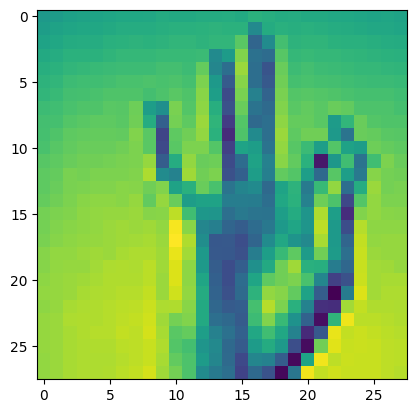

In [86]:
plt.imshow(images[1].reshape(28,28))
labels_test[1]

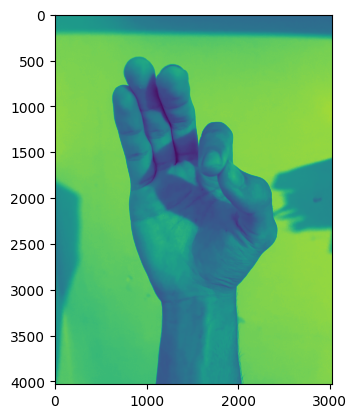

In [111]:
image_path = '/content/IMG_5954.jpg'
img = cv2.imread(image_path)

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display the grayscale image
plt.imshow(gray_img)

In [112]:
# Load the image using OpenCV
image_path = '/content/IMG_5954.jpg'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale

# Convert to a PIL Image
img_pil = Image.fromarray(img)

# Define the transformation to convert PIL Image to a PyTorch tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),  # Ensure the image size matches the model's expected input size
])

# Apply the transformation
array = transform(img_pil)

# Add a batch dimension (B, C, H, W)
array = array.unsqueeze(0)

# Move the tensor to the same device as the model
array = array.to(device)

In [113]:
model.eval()
# Disable gradient calculation
with torch.no_grad():
    output = model(array)
    prediction = torch.max(output.data, 1)
print(prediction)

torch.return_types.max(
values=tensor([0.0458], device='cuda:0'),
indices=tensor([5], device='cuda:0'))
